# This notebook plots REMA elevations on ICESAT1 lines

based a bit on radarlines_over_REMA but trying to compare icesat1 lines to new REMA data

- code to produce data at /Users/home/whitefar/DATA/code/REMOTE_SENSING/REMA/ICESAT1_lines_over_REMA.py, which writes REMA altitudes to shapefiles of icesat1 lines at /Users/home/whitefar/DATA/REMOTE_SENSING/ICESAT1/shapefiles_of_icesat1_over_channel/
- The coordinates are created in /home/arran/PHD/DATA/code/REMOTE_SENSING/ICESAT/icesat1_save_df_of_lines_residuals.py and saved to shapefile at DATA/Jupyter/ICESAT1/ICESAT1_fixing_blocky_residual_problems.ipynb

In all REMA code i use index from original file (REMA_Strip_Index_Rel1.shp) to refer to specific stripes 

- "x > -382064.5722209641 & x < -374781.1654740692 & y > -734075.0820404041 & y < -722764.4514729496"

    NB extrapolation is done by x for 0211 and y for 0099, v important, must redo REMA projection if changing this

In [2]:

import rasterio as rio
import rasterio.mask
import fiona
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from scipy import interpolate

from shapely.geometry import LineString


gis_path ="/Users/home/whitefar/DATA/REMOTE_SENSING/ICESAT1/shapefiles_of_icesat1_over_channel/"
REMA_filepath = '/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/'

indicies_which_intersect_studyarea = np.loadtxt("/Users/home/whitefar/DATA/REMOTE_SENSING/REMA_2m_strips/indicies_which_intersect.txt").astype(int).tolist()
lines_files_paths = glob.glob(os.path.join(gis_path,"**.shp"),recursive=True)
lines_names = [os.path.splitext(os.path.split(line_file_path )[1])[0] for line_file_path in lines_files_paths]
REMA_shapes_df = gpd.read_file('/Users/home/whitefar/DATA/REMOTE_SENSING/REMA_2m_strips/REMA_Strip_Index_Rel1.shp',crs="EPSG:3031").iloc[indicies_which_intersect_studyarea]

DriverError: /Users/home/whitefar/DATA/REMOTE_SENSING/REMA_2m_strips/REMA_Strip_Index_Rel1.shp: No such file or directory

In [ ]:
#open the dictionary associating each line with REMA strips
with open(gis_path+'REMAnid_over_icesat1lines.txt','r') as f:
    ld = eval(f.read())


line_index = [x for x in zip(lines_names,range(len(lines_names)))]

#print the line names with an index
print(lines_names)

In [ ]:
print(ld['track0099smoothpoints'],ld['track0211smoothpoints'])

In [ ]:
REMAdf = gpd.read_file('/Users/home/whitefar/DATA/REMOTE_SENSING/REMA_2m_strips/REMA_Strip_Index_Rel1.shp')

In [ ]:
REMAdf.keys()

In [ ]:
rl = gpd.read_file(gis_path+'track0099smoothpoints'+".shp")
ld
rl.keys()

In [1]:

def plot_line(line_name, ld=ld, df=REMAdf,x_or_y='x',legend='date', remove_trend=True,lr=False):
    """
    Plots the icesat1line with REMA elevations.
    each elevation line has a linear line between first and last points removed, to try and reduce tide effects.
    only use this on lines perpendicular to channel
    """
    x_or_y_smooth = x_or_y + '_smooth'
    leg = []
    rl = gpd.read_file(gis_path+line_name+".shp")
    plt.figure(figsize=(17,10))
    for REMA in ld[line_name]:
        
        nid = int(REMA.split('_')[1])
        date = df.loc[nid].acquisitio
        #whether to flip line lr
        if (rl.geometry.x.iloc[0] - rl.geometry.x.iloc[-1]) < 0:
            lr=False
        else:
            lr=True
        
        if lr==True:
            remaline =  rl[REMA].iloc[::-1]
        else:
            remaline =  rl[REMA]
        if remove_trend==True:
            #make line from first to last point
            f = interpolate.interp1d( [rl[x_or_y_smooth].iloc[0],rl[x_or_y_smooth].iloc[-1]], [rl[REMA].iloc[0],rl[REMA].iloc[-1]])
            trendline = f(rl[x_or_y_smooth])
            if lr==True:
                plt.plot(rl[x_or_y_smooth],remaline-trendline[::-1])
            else:
                plt.plot(rl[x_or_y_smooth],remaline-trendline)
                    
        else:
            plt.plot(rl[x_or_y_smooth],remaline)
        plt.title(line_name)
        if legend=='date':
            leg.append(date)
        elif legend=='nid':
            leg.append(nid)
        
        
    plt.legend(leg) 
    plt.grid(True)
    plt.xlabel(f"{x_or_y}, (m)")
#     plt.xlim([-200,4500])
#     plt.ylim([-18,2])
    plt.show()
  

NameError: name 'ld' is not defined

In [26]:
def plot_line(line_name,REMAdf,x_or_y='x',legend='date',gis_path=gis_path):
    """
    Plots the icesat1line with REMA elevations.
    each elevation line has a linear line between first and last points removed, to try and reduce tide effects.
    only use this on lines perpendicular to channel
    """
    
    
    x_or_y_smooth = x_or_y + '_smooth'
    
    icesat1_rema = gpd.read_file(gis_path+line_name+".shp")
    
    #rema_lines are the colums:
    rema_lines = [pas for pas in icesat1_rema.keys().tolist() if 'RE_' in pas]
    plt.figure(figsize=(17,10))
    for rema in sorted(rema_lines):

        plt.plot(icesat1_rema[x_or_y_smooth],icesat1_rema[rema],'-.',label=f'REMA {rema[3:]}')

    plt.legend() 
    plt.grid(True)
    plt.xlabel(f"{x_or_y}, (m)")
    if x_or_y=='x':
        plt.xlim([-382064.5722209641, -374781.1654740692])
        plt.ylim([35,85])
    elif x_or_y == 'y':
        plt.xlim( [-734075.0820404041, -722764.4514729496])
        plt.ylim([20,65])
    plt.show()

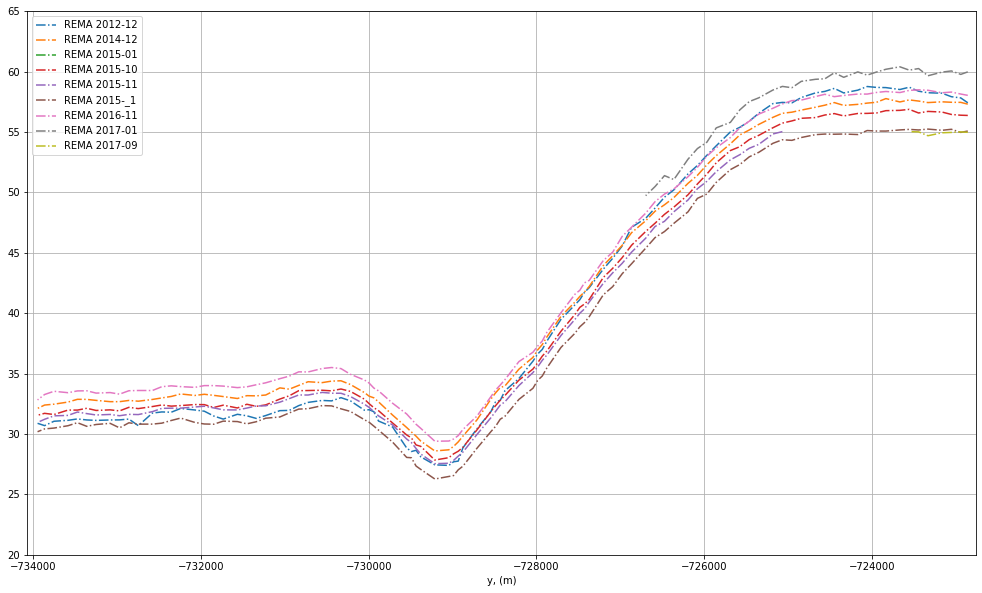

In [28]:
plot_line('track0099smoothpoints',REMAdf=REMAdf,x_or_y='y')

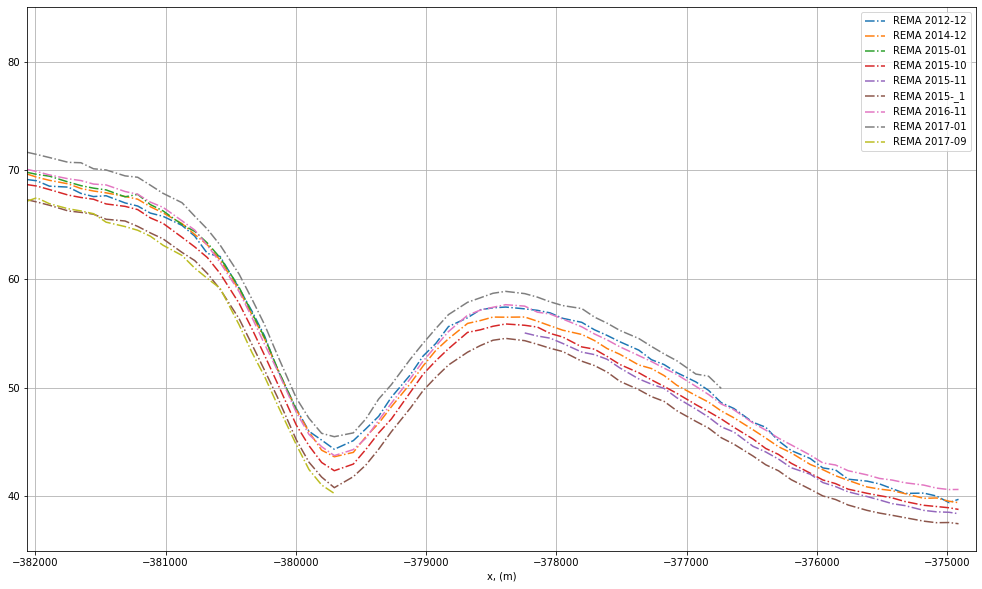

In [30]:
plot_line('track0211smoothpoints',REMAdf=REMAdf,x_or_y='x')

# Next add the icesat1 lines

In [31]:
icesat1_rema = gpd.read_file(gis_path+"track0099smoothpoints.shp")
icesat1_rema.keys()

Index(['x', 'pass_num', 'y', 'bin_number', 'dzdt', 'elev_wgs84', 'ret',
       'retide', 'sdatedays', 'z', 'UTCtime', 'zp', 'residual', 'dz', 'x_bin',
       'y_bin', 'x_smooth', 'y_smooth', 'zp_2004-05', 'dzdt_2004-',
       'dzdt_cum_2', 'zp_2005-06', 'dzdt_2005-', 'dzdt_cum_1', 'zp_2005-11',
       'dzdt_200_1', 'dzdt_cum_3', 'zp_2006-03', 'dzdt_2006-', 'dzdt_cum_4',
       'zp_2006-06', 'dzdt_200_2', 'dzdt_cum_5', 'zp_2006-11', 'dzdt_200_3',
       'dzdt_cum_6', 'zp_2008-03', 'dzdt_2008-', 'dzdt_cum_7', 'zp_2008-10',
       'dzdt_200_4', 'dzdt_cum_8', 'zp_2008-11', 'dzdt_200_5', 'dzdt_cum_9',
       'zp_2009-03', 'dzdt_2009-', 'dzdt_cum10', 'RE_2015-11', 'RE_2015-10',
       'RE_2016-11', 'RE_2014-12', 'RE_2017-01', 'RE_2017-09', 'RE_2015-01',
       'RE_2015-_1', 'RE_2012-12', 'geometry'],
      dtype='object')

In [32]:
def plot_line_REMA_icesat1(line_name,REMAdf,x_or_y='x',legend='date',gis_path=gis_path):
    """
    Plots the icesat1line with REMA elevations.
    each elevation line has a linear line between first and last points removed, to try and reduce tide effects.
    only use this on lines perpendicular to channel
    """

    
    x_or_y_smooth = x_or_y + '_smooth'
    
    icesat1_rema = gpd.read_file(gis_path+line_name+".shp")
    
    #icesat lines are the columns:
    icesat1_lines = [pas for pas in icesat1_rema.keys().tolist() if 'zp_' in pas] # all column names with 'zp_'
    plt.figure(figsize=(17,10))
    for icesat1 in icesat1_lines:
        plt.plot(icesat1_rema[x_or_y_smooth],icesat1_rema[icesat1],':',label=f'ICESAT1 {icesat1[3:]}')
        
    #rema_lines are the colums:
    rema_lines = [pas for pas in icesat1_rema.keys().tolist() if 'RE_' in pas]
    
    for rema in sorted(rema_lines):

        plt.plot(icesat1_rema[x_or_y_smooth],icesat1_rema[rema],'-.',label=f'REMA {rema[3:]}')

    plt.legend() 
    plt.grid(True)
    plt.xlabel(f"{x_or_y}, (m)")
    if x_or_y=='x':
        plt.xlim([-382064.5722209641, -374781.1654740692])
        plt.ylim([35,85])
    elif x_or_y == 'y':
        plt.xlim( [-734075.0820404041, -722764.4514729496])
        plt.ylim([20,65])
    plt.show()


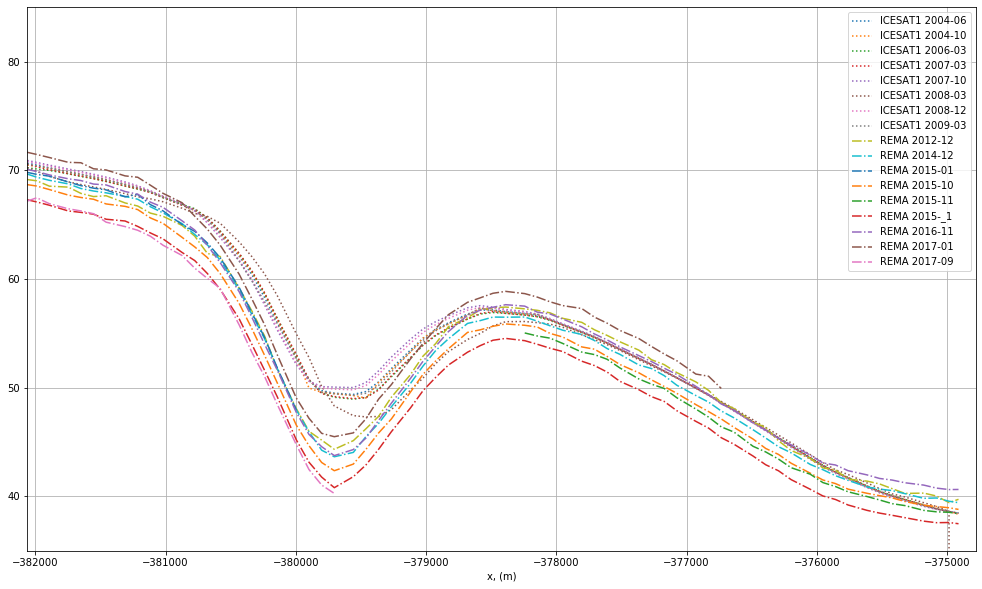

In [33]:
plot_line_REMA_icesat1('track0211smoothpoints',REMAdf,x_or_y='x')

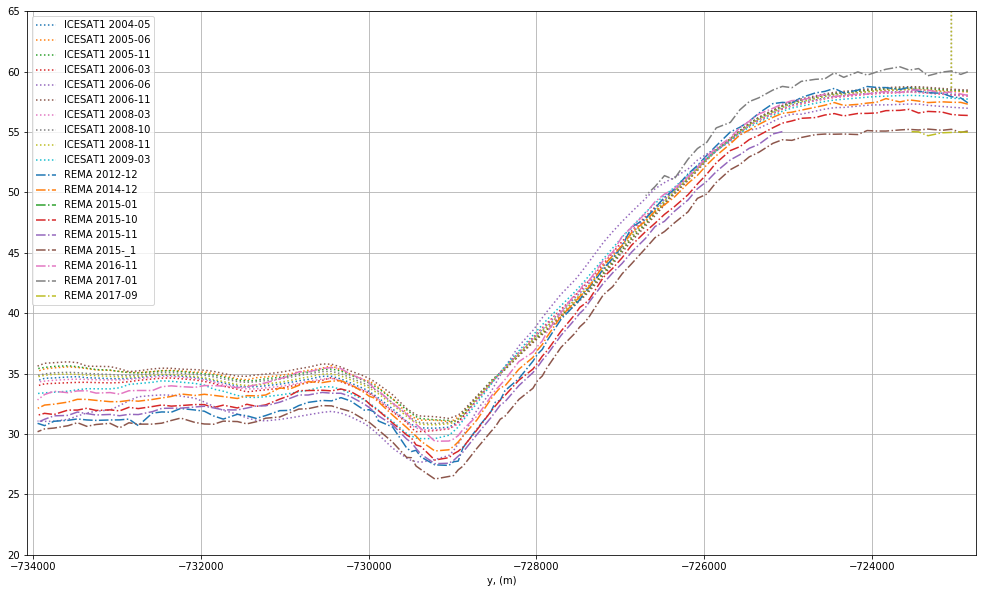

In [34]:
plot_line_REMA_icesat1('track0099smoothpoints',REMAdf,x_or_y='y')

In [35]:
def plot_diffs_REMA_icesat1(line_name,REMAdf,x_or_y='x',legend='date',gis_path=gis_path):
    """
    Plots the icesat1line with REMA elevations.
    each elevation line has a linear line between first and last points removed, to try and reduce tide effects.
    only use this on lines perpendicular to channel
    """

    
    x_or_y_smooth = x_or_y + '_smooth'
    
    icesat1_rema = gpd.read_file(gis_path+line_name+".shp")
    
    #icesat lines are the columns:
    icesat1_lines = [pas for pas in icesat1_rema.keys().tolist() if 'zp_' in pas] # all column names with 'zp_'
    
    line0 = icesat1_rema[icesat1_lines[0]].to_numpy()
    
    plt.figure(figsize=(17,10))
    
    #plot icesat lines
    for icesat1 in icesat1_lines[1:]:
        diff = icesat1_rema[icesat1].to_numpy() - line0
        plt.plot(icesat1_rema[x_or_y_smooth],diff,':',label=f'ICESAT1 {icesat1[3:]}')
        del diff
        
    #rema_lines are the colums:
    rema_lines = [pas for pas in icesat1_rema.keys().tolist() if 'RE_' in pas]
    
    #plot rema lines
    for rema in sorted(rema_lines):
        try: #because theres some error with nonetype data
            diff = icesat1_rema[rema].to_numpy() - line0
            plt.plot(icesat1_rema[x_or_y_smooth],diff,'-.',label=f'REMA {rema[3:]}')
            del diff
        except TypeError: 
            print(f"{rema} has no data")

    plt.legend() 
    plt.grid(True)
    plt.xlabel(f"{x_or_y}, (m)")
    if x_or_y=='x':
        plt.xlim([-382064.5722209641, -374781.1654740692])
        plt.ylim([-10,10])
    elif x_or_y == 'y':
        plt.xlim( [-734075.0820404041, -722764.4514729496])
        plt.ylim([-10,10])
    plt.show()


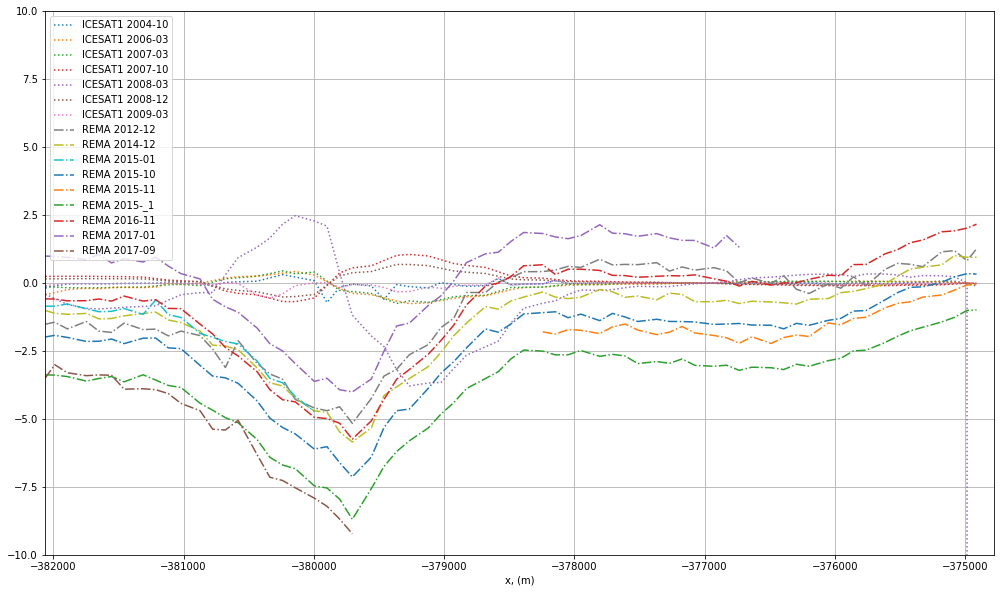

In [36]:
plot_diffs_REMA_icesat1('track0211smoothpoints',REMAdf,x_or_y='x')

RE_2015-01 has no data


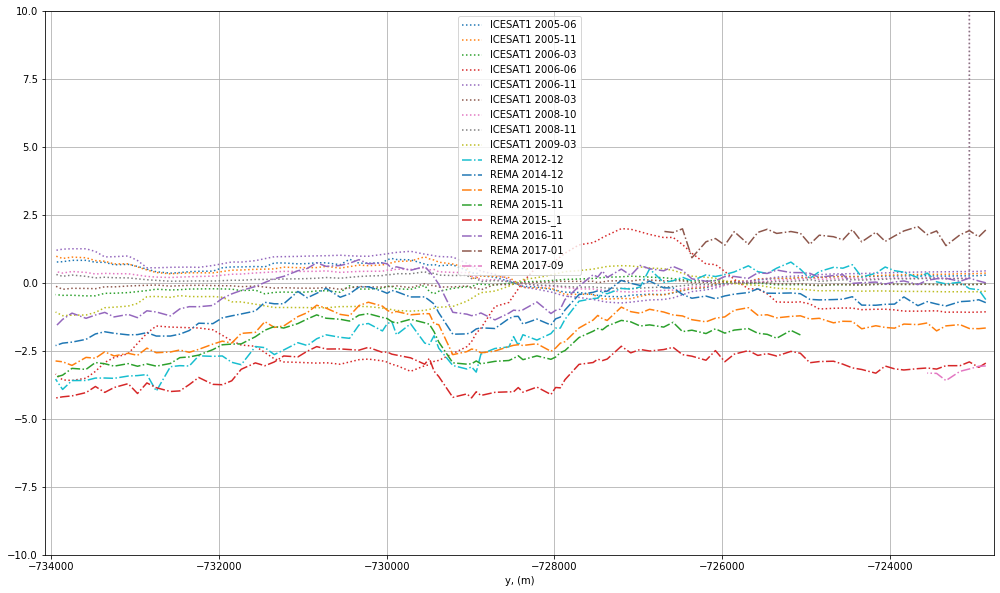

In [37]:
plot_diffs_REMA_icesat1('track0099smoothpoints',REMAdf,x_or_y='y')